<div style="display: flex;">
    <div style="width:100px; text-align:center;">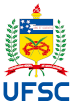</div>
    <div style="width: 100%; text-align: center;"><h1>Universidade Federal de Santa Catarina<br/>Centro Tecnológico<br/>Departamento de Informática e Estatística</h1></div>
    <div style="width:100px; text-align:center;">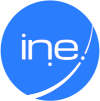</div>
</div>

<h3><strong>Disciplina:</strong> INE5664 - Aprendizado de Máquina<br/>
<strong>Turma:</strong> 07238<br/>
<strong>Curso:</strong> Sistemas de Informação<br/>
<strong>Professor:</strong> Eduardo Camilo Inacio<br/>
<strong>Alunos:</strong> Acaua Pitta, Isac Martins, Lucas Cunha</h3>

<h2>Processo de Classificação Multiclasse com Rede Neural Personalizada</h2>

<h3>Introdução e Configuração do Ambiente</h3>

In [1]:
import sys
import os

# Add the parent directory of 'src' to sys.path
sys.path.append(os.path.abspath('../src'))

### Importação de Bibliotecas
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from neural_network.utils import one_hot_encode, normalize_data, plot_single_confusion_matrix, plot_loss_and_accuracy_curve, display_final_metrics, plot_confusion_matrices_side_by_side, print_metrics_legend
from neural_network.losses import CategoricalCrossEntropyLoss
from neural_network.layers.dense_layer import DenseLayer
from neural_network.layers.dense_l2_layer import L2DenseLayer
from neural_network.layers.dropout_layer import DropoutLayer
from neural_network.optimizer import GradientDescent
from neural_network.neural import NeuralNetwork


<h3>Leitura e Pré-processamento Inicial dos Dados</h3>

In [2]:
# Carregar o arquivo CSV
data = pd.read_csv('../data/multiclass/online_gaming_behavior.csv')

# Exibir primeiras linhas do dataset
data.head()

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium


In [3]:
# Selecionar colunas categóricas
categorical_columns = ['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel']

# Mapear cada categoria para um número
for column in categorical_columns:
    data[column] = data[column].astype('category').cat.codes

# Obter o número de classes para cada coluna categórica
num_classes = {column: data[column].nunique() for column in categorical_columns}

# Aplicar One-Hot Encoding
for column in categorical_columns:
    one_hot_encoded = one_hot_encode(data[column].values, num_classes[column])

    # Adicionar as colunas one-hot ao dataframe
    for i in range(num_classes[column]):
        data[f"{column}_{i}"] = one_hot_encoded[:, i]

    # Remover a coluna categórica original
    data = data.drop(column, axis=1)

# Exibir o dataset transformado
data.head()

,PlayerID,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,Gender_0,Gender_1,...,GameGenre_1,GameGenre_2,GameGenre_3,GameGenre_4,GameDifficulty_0,GameDifficulty_1,GameDifficulty_2,EngagementLevel_0,EngagementLevel_1,EngagementLevel_2
0,9000,43,16.271119,0,6,108,79,25,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,9001,29,5.525961,0,5,144,11,10,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,9002,22,8.223755,0,16,142,35,41,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,9003,35,5.265351,1,9,85,57,47,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,9004,33,15.531945,0,2,131,95,37,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [4]:
# Definir X (entrada) e y (saída)
cleared_data = data.drop(['PlayerID', 'EngagementLevel_0', 'EngagementLevel_1', 'EngagementLevel_2'], axis=1)
print(cleared_data.columns)

X = cleared_data.values
y = one_hot_encode(data[['EngagementLevel_0', 'EngagementLevel_1', 'EngagementLevel_2']].values.argmax(axis=1), 3)

# Normalizar os dados de entrada
X = normalize_data(X)

# Dividir em TREINO e TESTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir os dados de TREINO em TREINO e VALIDAÇÃO
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


Index(['Age', 'PlayTimeHours', 'InGamePurchases', 'SessionsPerWeek',
       'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked',
       'Gender_0', 'Gender_1', 'Location_0', 'Location_1', 'Location_2',
       'Location_3', 'GameGenre_0', 'GameGenre_1', 'GameGenre_2',
       'GameGenre_3', 'GameGenre_4', 'GameDifficulty_0', 'GameDifficulty_1',
       'GameDifficulty_2'],
      dtype='object')


<h3>Configuração da Rede Neural e Inicialização do Modelo</h3>

In [5]:
input_size = X_train.shape[1] #Neurônios de entrada
output_size = y_train.shape[1] #Neurônios de saída

layers = [
    L2DenseLayer(input_size=input_size, output_size=64, activation='relu'),
    DropoutLayer(rate=0.2),
    DenseLayer(input_size=64, output_size=32, activation='relu'),
    DenseLayer(input_size=32, output_size=output_size, activation='softmax'),
]

loss = CategoricalCrossEntropyLoss()
optimizer = GradientDescent(learning_rate=0.0175)

# Criar o modelo
model = NeuralNetwork(layers=layers, loss=loss, optimizer=optimizer)

<h3>Treinamento da Rede Neural</h3>

In [6]:
# Configurações do tamanho do batch dinâmico
initial_batch_size = 128
final_batch_size = 4096
batch_growth_rate = 5  # Taxa de aumento por época

epochs = 500
best_val_loss = float('inf')
early_stop_threshold = 5
no_improvement = 0

initial_learning_rate = optimizer.learning_rate
decay_rate = 0.001
decay_step = 10

loss_history = []
val_loss_history = []
accuracy_history = []
val_accuracy_history = []

# Timer
start_time = time.time()

# Treinar a rede neural
for epoch in range(epochs):
    # Ajustar Learning Rate
    if epoch % decay_step == 0 and epoch > 0:
        optimizer.learning_rate *= (1 - decay_rate)
        print(f"\nAdjusted Learning Rate: {optimizer.learning_rate:.6f}\n")
    
    # Atualizar o tamanho do batch
    batch_size = min(initial_batch_size + epoch * batch_growth_rate, final_batch_size)

    # Dividir os dados em batches
    num_batches = int(np.ceil(X_train.shape[0] / batch_size))
    epoch_loss = 0
    epoch_accuracy = 0

    for batch in range(num_batches):
        # Criar batches
        start = batch * batch_size
        end = min((batch + 1) * batch_size, X_train.shape[0])
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]

        # Forward pass
        y_pred = model.forward(X_batch)

        # Calcular perdas e métricas
        batch_loss = loss.calculate(y_batch, y_pred)
        batch_accuracy = accuracy_score(y_batch.argmax(axis=1), y_pred.argmax(axis=1))

        # Atualizar perdas e acurácia por batch
        epoch_loss += batch_loss
        epoch_accuracy += batch_accuracy

        # Backward e update
        model.backward(y_batch, y_pred)
        model.update()

    # Média das métricas por época
    epoch_loss /= num_batches
    epoch_accuracy /= num_batches

    # Validação
    y_val_pred = model.forward(X_val)
    val_loss = loss.calculate(y_val, y_val_pred)
    val_accuracy = accuracy_score(y_val.argmax(axis=1), y_val_pred.argmax(axis=1))

    # Guardar históricos
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= early_stop_threshold:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Relatório a cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch + 1} - Batch Size: {batch_size}\n"
            f" Train -> Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}\n"
            f" Validation -> Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}"
        )

# Após o treinamento
elapsed_time = time.time() - start_time
print(f"__________________________________________________________")
print(f"\nElapsed Time: {elapsed_time:.2f}s")


Epoch 10 - Batch Size: 173
 Train -> Loss: 0.8432, Accuracy: 0.6223
 Validation -> Loss: 0.8333, Accuracy: 0.6317

Adjusted Learning Rate: 0.017483

Epoch 20 - Batch Size: 223
 Train -> Loss: 0.7158, Accuracy: 0.7099
 Validation -> Loss: 0.7160, Accuracy: 0.7157

Adjusted Learning Rate: 0.017465

Epoch 30 - Batch Size: 273
 Train -> Loss: 0.6588, Accuracy: 0.7497
 Validation -> Loss: 0.6621, Accuracy: 0.7502

Adjusted Learning Rate: 0.017448

Epoch 40 - Batch Size: 323
 Train -> Loss: 0.6306, Accuracy: 0.7676
 Validation -> Loss: 0.6329, Accuracy: 0.7683

Adjusted Learning Rate: 0.017430

Epoch 50 - Batch Size: 373
 Train -> Loss: 0.6134, Accuracy: 0.7799
 Validation -> Loss: 0.6144, Accuracy: 0.7816

Adjusted Learning Rate: 0.017413

Epoch 60 - Batch Size: 423
 Train -> Loss: 0.6001, Accuracy: 0.7882
 Validation -> Loss: 0.6015, Accuracy: 0.7896

Adjusted Learning Rate: 0.017395

Epoch 70 - Batch Size: 473
 Train -> Loss: 0.5953, Accuracy: 0.7922
 Validation -> Loss: 0.5920, Accuracy:

<h3>Avaliação do Modelo e Métricas de Desempenho</h3>

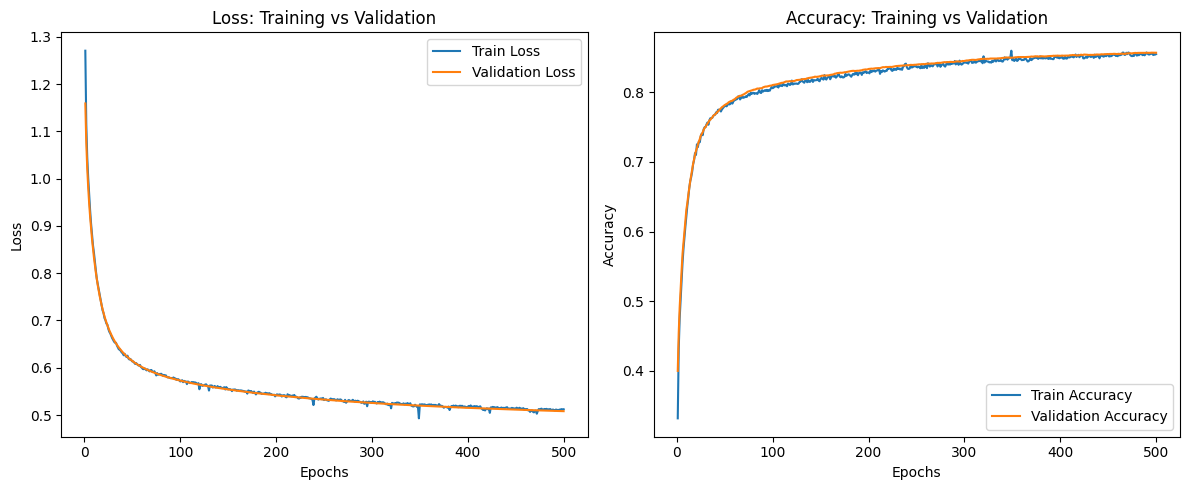

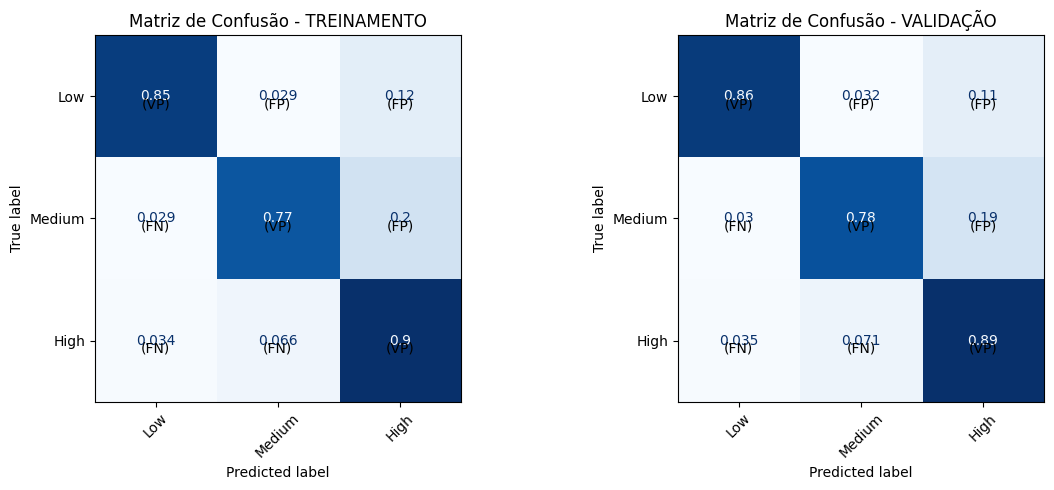


Métricas Finais:
              Metric    Value
             Camadas        4
       Learning Rate 0.016663
    Batch Size Final     2623
        Elapsed Time   37.54s
      Train Accuracy   0.8546
         Train Error   0.1454
          Train Loss   0.5123
 Validation Accuracy   0.8566
    Validation Error   0.1434
     Validation Loss   0.5082
Validation Precision   0.8569
   Validation Recall   0.8566
 Validation F1-Score   0.8562

    Legenda de Métricas:

    - Acurácia (Accuracy): Proporção de previsões corretas sobre o total de amostras.
      Fórmula: (VP + VN) / (VP + VN + FP + FN)
      
    - Precisão (Precision): Proporção de previsões corretas entre todas as previsões positivas feitas.
      Fórmula: VP / (VP + FP)
      Indica o quão confiável é o modelo quando prevê uma classe como positiva.

    - Sensibilidade (Recall): Proporção de positivos corretamente identificados pelo modelo.
      Fórmula: VP / (VP + FN)
      Mede a capacidade do modelo de encontrar todas as oc

In [7]:
# Relatórios finais
labels = ["Low", "Medium", "High"]

# Cálculo de métricas detalhadas para VALIDAÇÃO
val_true = y_val.argmax(axis=1)  # Rótulos verdadeiros
val_pred = y_val_pred.argmax(axis=1)  # Previsões

y_train_pred = model.forward(X_train).argmax(axis=1)  # Previsões para o treino
y_train_true = y_train.argmax(axis=1)                 # Rótulos verdadeiros para o treino

val_precision = precision_score(val_true, val_pred, average="weighted")
val_recall = recall_score(val_true, val_pred, average="weighted")
val_f1 = f1_score(val_true, val_pred, average="weighted")

# Gráficos Loss e Accuracy - TREINAMENTO/VALIDAÇÃO
plot_loss_and_accuracy_curve(loss_history, val_loss_history, accuracy_history, val_accuracy_history)

# Matriz de Confusão na TREINAMENTO/VALIDAÇÃO
plot_confusion_matrices_side_by_side(
    y_train_true=y_train_true,
    y_train_pred=y_train_pred,
    y_val_true=val_true,
    y_val_pred=val_pred,
    labels=labels
)

# Após o treinamento, chamar a função para exibir as métricas
display_final_metrics(
    epoch_accuracy=epoch_accuracy,
    epoch_loss=epoch_loss,
    val_accuracy=val_accuracy,
    val_loss=val_loss,
    val_precision=val_precision,
    val_recall=val_recall,
    val_f1=val_f1,
    model=model,
    optimizer=optimizer,
    batch_size=batch_size,
    elapsed_time=elapsed_time
)

print_metrics_legend()


Métricas Finais - TESTE:

Métricas Finais:
        Metric    Value
       Camadas        4
 Learning Rate 0.016663
  Elapsed Time    0.02s
 Test Accuracy   0.8490
    Test Error   0.1510
Test Precision   0.8497
   Test Recall   0.8490
 Test F1-Score   0.8484

    Legenda de Métricas:

    - Acurácia (Accuracy): Proporção de previsões corretas sobre o total de amostras.
      Fórmula: (VP + VN) / (VP + VN + FP + FN)
      
    - Precisão (Precision): Proporção de previsões corretas entre todas as previsões positivas feitas.
      Fórmula: VP / (VP + FP)
      Indica o quão confiável é o modelo quando prevê uma classe como positiva.

    - Sensibilidade (Recall): Proporção de positivos corretamente identificados pelo modelo.
      Fórmula: VP / (VP + FN)
      Mede a capacidade do modelo de encontrar todas as ocorrências da classe positiva.

    - F1-Score: Média harmônica entre Precisão e Sensibilidade.
      Fórmula: 2 * (Precision * Recall) / (Precision + Recall)
      Útil quando há

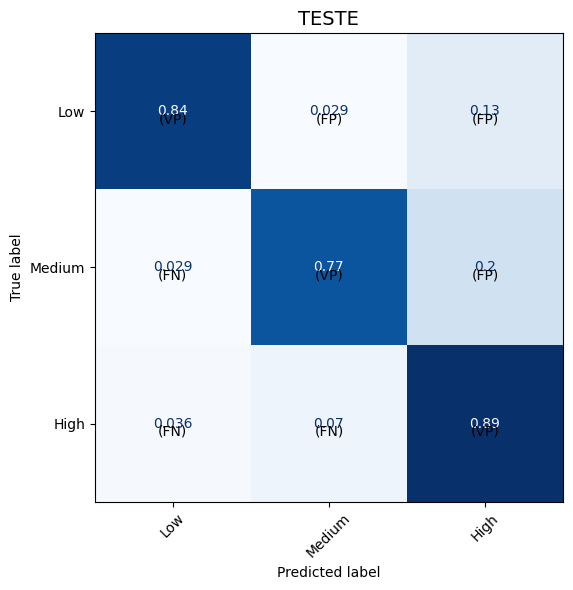

In [8]:
start_time = time.time()

# Fazer previsões no conjunto de teste
y_test_pred = model.forward(X_test).argmax(axis=1)
y_test_true = y_test.argmax(axis=1)

# Calcular métricas
test_accuracy = accuracy_score(y_test_true, y_test_pred)
test_precision = precision_score(y_test_true, y_test_pred, average="weighted")
test_recall = recall_score(y_test_true, y_test_pred, average="weighted")
test_f1 = f1_score(y_test_true, y_test_pred, average="weighted")
elapsed_time = time.time() - start_time

# Relatório de métricas finais para teste
print(f"\nMétricas Finais - TESTE:")
display_final_metrics(
    test_accuracy=test_accuracy,
    test_precision=test_precision,
    test_recall=test_recall,
    test_f1=test_f1,
    model=model,
    optimizer=optimizer,
    elapsed_time=elapsed_time
)

# Matriz de confusão para teste
plot_single_confusion_matrix(y_test_true, y_test_pred, labels=labels, title="TESTE")